<a href="https://colab.research.google.com/github/junranshi/capstone_moonboard/blob/main/Generation_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info
In this notebook I implement the final setup for the variational autoencoder model to generate routes for each grade.  
Each model is specific to a grade and trained using 200 samples of routes of that grade for 20 epochs. The VAE model has a latent space of 50 dimensions. The structure of the VAE model can be found below.  
Using this model, we then generate routes to be displayed on the website and routes of grades V78-10+ to be used for oversampling in our grade classification studies.

# Import packages and dataset

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import pickle
import random

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss

from sklearn.model_selection import train_test_split # for getting training / testing data

from tensorflow import keras # for building Neural Networks
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Reshape
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# for displaying routes
import cv2

# for saving data
import pickle

In [2]:
!git clone https://github.com/junranshi/capstone_moonboard.git

Cloning into 'capstone_moonboard'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 438 (delta 26), reused 31 (delta 12), pack-reused 389
Receiving objects: 100% (438/438), 72.10 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (212/212), done.


In [3]:
# load dataset
with open('/content/capstone_moonboard/data/cleaned.p', 'rb') as f:
    mb_2016 = pickle.load(f)

# get MB background image
mb_2016_img = cv2.imread('/content/capstone_moonboard/images/mb_2016_img.jpeg')

# Define functions to be used

In [5]:
def filter_routes_grade(data, grade):
  """
  return a list of routes of a certain grade
  """
  routes = {}
  for key in data:
    item = data[key]
    if item['grade'] == grade:
      routes[key] = item
  return routes

# make a list of all routes separated by their grades
routes_by_grade = [filter_routes_grade(mb_2016, grade) for grade in range(7)]

In [6]:
# generate a dictionary of the number of holds for routes of each grade
n_of_holds_dict = {}
for grade in range(7):
    n_of_holds_dict[grade] = [[],[],[]]

# separate start, intermediate, and finish holds
for key, item in mb_2016.items():
    grade = item['grade']
    n_of_holds_dict[grade][0].append(len(item['start']))
    n_of_holds_dict[grade][1].append(len(item['mid']))
    n_of_holds_dict[grade][2].append(len(item['end']))

In [7]:
def get_coor(hold):
    """
    return the coordinates of a hold to be circled on the moonboard image
    """
    x, y = hold
    x_coor = 94 + x*51
    y_coor = 958 - y*51
    return (int(x_coor), int(y_coor))

def add_hold(hold, img, hold_type='mid'):
    """
    add hold to moonboard image
    """
    circle_color = {
        'start': (0,255,0),
        'mid': (255,0,0),
        'end': (0,0,255),
    }
    center = get_coor(hold)
    c = circle_color[hold_type]
    cv2.circle(img = img, center = center, radius = 28, color = c, thickness=5)

def get_X_y(samples):
    """
    return the routes and grades respectively for a given sample of routes
    """
    X_start = get_matrices(samples, ['start'])[1]
    X_mid = get_matrices(samples, ['mid'])[1]
    X_end = get_matrices(samples, ['end'])[1]

    X = np.zeros((len(samples), 18, 11, 3))
    for i in range(len(samples)):
      sample = np.dstack((X_start[i], X_mid[i], X_end[i]))
      X[i] = sample
    y = np.array([samples[x]['grade'] for x in samples])
    return X, y

def get_holds(item, hold_types):
    """
    get a list of holds from a route
    input hold_types is a list of combination of 'start', 'mid', 'end'
    """
    route = []
    for t in hold_types:
        for hold in item[t]:
            route.append(hold)
    return route

def convert_matrix(list):
    """
    one hot encode a list of holds to 11*18 binary matrix
    """
    matrix = np.zeros((11,18))
    for hold in list:
        x = hold[0]
        y = hold[1]
        matrix[x][y] = 1
    return matrix

def display_matrix(matrix):
    """
    flip the matrix to present as 18*11
    """
    return np.flip(matrix.T, 0)

def get_matrices(data, hold_types):
    """
    return a dictionary and a list of matrices for the data input (eg mb_2016)
    """
    d = {}
    l = []
    for key in data:
        route = get_holds(data[key], hold_types)
        d[key] = display_matrix(convert_matrix(route))
        l.append(display_matrix(convert_matrix(route)))
    return d, l

def number_to_xy(n):
    """
    return moonboard coordinates for a hold based on its index
    """
    x = 17-n//11
    y = n%11
    return [y,x]

In [8]:
# functions to interpret outputs of VAE model

def display_route(route):
    """
    display an entire route on an image
    """
    img = mb_2016_img.copy()
    if type(route) == dict:
      for key, item in route.items():
          # key is hold type, item is list of holds
          for hold in item:
              add_hold(hold, img, key)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def stack_route(raw_pred):
  """
  take the output from a generative model and merge the three channels together into one matrix representation
  """
  stacked_route = np.zeros((18,11,1))
  for i in range(18):
    for j in range(11):
      stacked_route[i,j] = sum(raw_pred[0][i][j])
  return stacked_route.reshape([18,11])

def filter_route(raw_pred, holds):
    """
    take the number of holds for a generated route and choose holds
    return a dictionry of start, intermediate, and finish holds
    """
    # flatten each of the three matrices
    df = pd.DataFrame({'index': range(198), 'start': raw_pred[:,:,0].flatten(), 'mid': raw_pred[:,:,1].flatten(), 'end': raw_pred[:,:,2].flatten()})
    # find the required number of holds
    n_start = holds[0]
    n_mid = holds[1]
    n_end = holds[2]

    # get top 3 start holds
    df_start = df.sort_values('start', ascending=False).head(3)

    df_mid = df.sort_values('mid', ascending=False).head(n_mid)
    # get top 2 finish holds
    df_end = df.sort_values('end', ascending=False).head(2)

    # randomly choose n_start holds out of 3 top start holds
    start = random.sample([number_to_xy(n) for n in df_start['index'].tolist()], n_start)
    mid = [number_to_xy(n) for n in df_mid['index'].tolist()]
    # randomly choose n_end holds out of 2 top start holds
    end = random.sample([number_to_xy(n) for n in df_end['index'].tolist()], n_end)

    return {'start': start, 'mid': mid, 'end': end}

def display_generated_route(latent_input, decoder, grade, show_raw = True, show_holds = True, return_route = False):
    """
    complete function to take an input latent vector and interpret it into a moonboard route
    returns an image of the route and a list of the route holds
    """
    # use the decoder to generate a route using the latent vector
    digit_decoded = decoder.predict([latent_input], verbose=0)
    # choose numbers of holds for start, intermediate, and finish holds respectively
    start = random.choice(n_of_holds_dict[grade][0])
    mid = random.choice(n_of_holds_dict[grade][1])
    end = random.choice(n_of_holds_dict[grade][2])
    # filter the route based on number of holds
    route = filter_route(digit_decoded[0], holds = [start, mid, end])

    # visualize raw output
    if show_raw:
      print('Latent input:', latent_input)
      print('\nVisualized output:')
      plt.matshow(stack_route(digit_decoded))
      plt.colorbar(fraction=0.044*18/11)
      plt.show()

    # visualize route
    if show_holds:
      print('\nFiltered Routes Based on Number of Holds:')
      fig, axes = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')

      for i in range(3):
        axes[i].imshow(display_route(filter_route(digit_decoded[0], holds = [start, mid, end])))
        axes[i].axis('off')
        axes[i].set_title('Holds Config:'+str(holds_config[i]), fontsize =12)
      plt.show()

    # return the route image and the route list
    if return_route:
      route = filter_route(digit_decoded[0], holds = [start, mid, end])
      return display_route(route), route

In [10]:
# functions to define and train the model

def vis_history(history):
    """
    visualize training history (loss vs epochs graph)
    """
    fig, ax = plt.subplots(figsize=(16,9), dpi=70)
    plt.title(label='Model Loss by Epoch', loc='center')
    ax.plot(history.history['loss'], label='Training Data', color='black')
    ax.plot(history.history['val_loss'], label='Test Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
    plt.legend()
    plt.show()

def sampling(args):
    """
    sampling function to randomly sample from latent space distribution
    epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
    z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
    """
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

# Define VAE model

In [11]:
channels_dim = 3 # one channel for start, mid, end respetively
original_dim = (18, 11, channels_dim) 
latent_dim = 50 # latent space dimension

# Reference for using 2DConv: https://github.com/pbr142/vae/blob/main/VAE_CIFAR10.ipynb

def vae_3_channels():
  """
  set up variational autoencoder, return the encoder, decoder, and the entire model
  """
  # ********** Create Encoder **********

  #--- Input Layer
  visible = keras.Input(shape=original_dim, name='Encoder-Input-Layer')

  #--- Hidden Layers
  h_enc1 = Flatten()(visible)
  h_enc2 = Dense(units=32, activation='relu', name='Encoder-Hidden-Layer-1')(h_enc1)
  h_enc3 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc2)
  h_enc4 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc3)

  #--- Custom Latent Space Layer
  z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc4) # Mean component
  z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc4) # Standard deviation component
  z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

  # ********** Create Decoder **********

  #--- Input Layer 
  latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

  #--- Hidden Layer
  h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
  h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
  h_dec3 = Dense(units=32, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

  #--- Output Layer
  outputs = Dense(units = 594, activation='relu', name='Decoder-Output-Layer')(h_dec3)
  outputs = Reshape(original_dim)(outputs)

  #--- Create Encoder model
  encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

  #--- Create Decoder model
  decoder = Model(latent_inputs, outputs, name='Decoder-Model')

  # Define outputs from a VAE model by specifying how the encoder-decoder models are linked
  outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]

  r_loss = K.mean(keras.losses.mse(visible, outpt), axis=(1,2)) * 18 * 11
  kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
  vae_loss = K.mean(r_loss + kl_loss)

  vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')

  return encoder, decoder, vae

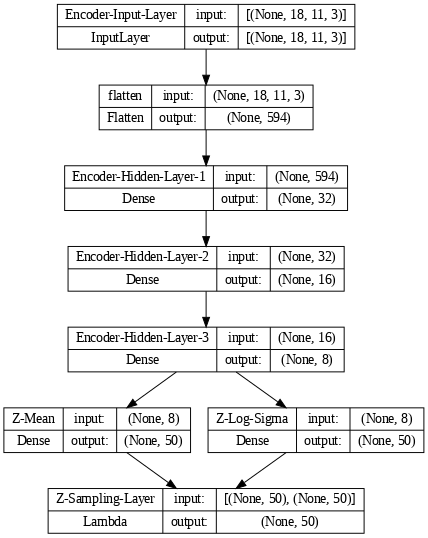

In [12]:
# plot model structures
encoder, decoder, vae = vae_3_channels()
plot_model(encoder, show_shapes=True, dpi=70)

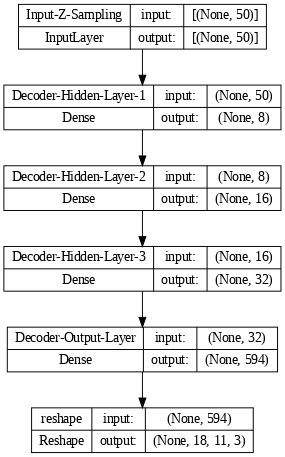

In [13]:
plot_model(decoder, show_shapes=True, dpi=70)

# Train models for each grade
We use the VAE model defined above and train a model for each grade using 200 samples. We train the model for 20 epochs with a latent space dimension of 50. The resulting routes are displayed in the code cells below.

In [14]:
latent_dim = 50
EPOCHS = 20

def train_generator(grade, n_sample, history = False):
    """
    given the grade and number of samples, train a variational autoencoder to generate routes
    return the trained decoder
    if history == True, show training loss graph
    """
    X, _ = get_X_y(routes_by_grade[grade])
    X = np.array(random.sample(list(X), n_sample))
    X_train, X_test = train_test_split(X, test_size=0.2)
    encoder, decoder, vae = vae_3_channels()
    
    if history == True:
        history = vae.fit(X_train, X_train, epochs = EPOCHS, validation_data=(X_test, X_test), verbose = False)
        vis_history(history)
    else:
        vae.fit(X_train, X_train, epochs = EPOCHS, validation_data=(X_test, X_test), verbose = False)
    return decoder


def generate_route(grade, decoder):
    input = [random.uniform(-4,4) for i in range(latent_dim)]
    plt.figure(dpi=300)
    route_img, route = display_generated_route(input, decoder, grade, show_raw = False, show_holds = False, return_route=True)
    return route_img, route

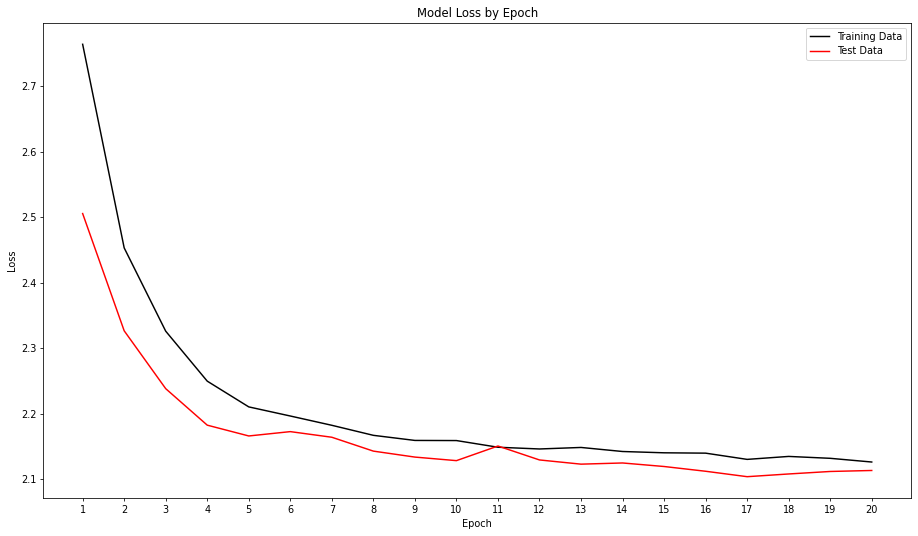

In [20]:
# see training process for V9 routes
train_generator(5, 200, history = True)

Generate route: {'start': [[6, 1], [5, 4]], 'mid': [[7, 9], [4, 7], [4, 9], [6, 12], [4, 14], [9, 7], [6, 7]], 'end': [[4, 17]], 'grade': 6}

Image:


<Figure size 1800x1200 with 0 Axes>

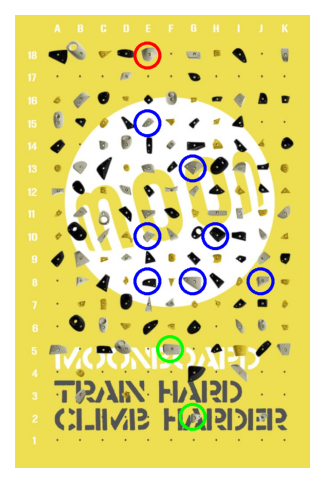

In [33]:
# example: train a model and generate one V4 route
decoder_0 = train_generator(0, 200, history = False)
route_img, route = generate_route(0, decoder_0)
route['grade'] = grade
print('Generate route:', route)

print('\nImage:')
plt.figure(dpi=150)
plt.imshow(route_img)
plt.axis('off')
plt.show()

In [24]:
# each model is trained on 200 samples
N_SAMPLE = 200
N_GRADES = 7
N_ROUTESPERGRADE = 6

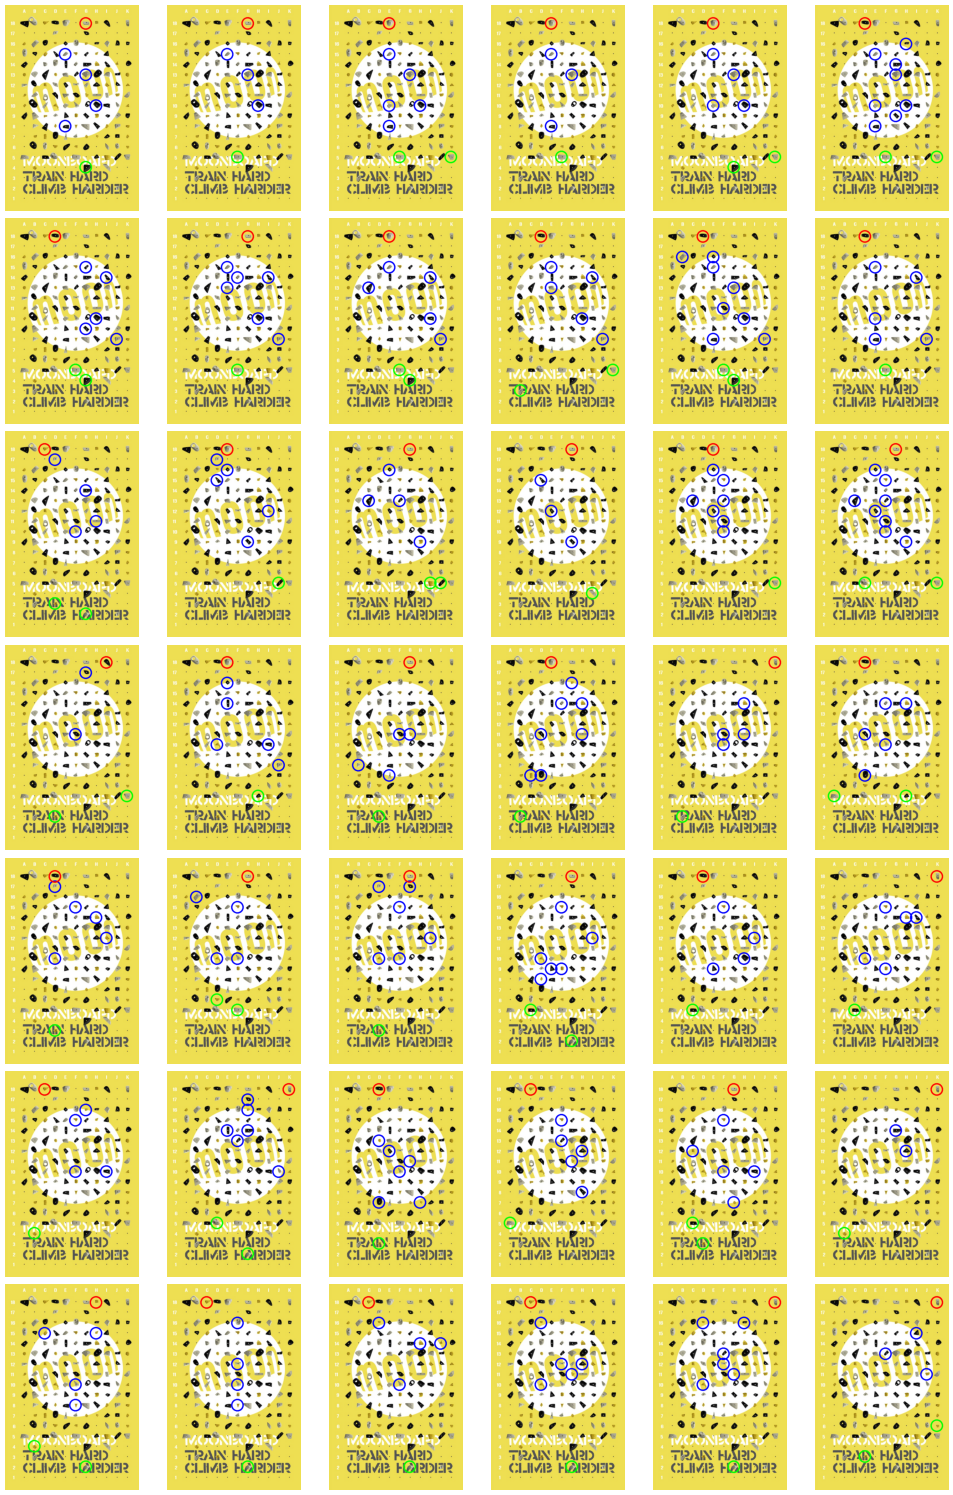

In [25]:
# generate 6 routes per grade and display them
fig, axs = plt.subplots(N_GRADES, N_ROUTESPERGRADE, tight_layout = True, figsize=(20, 30), dpi=50, facecolor='white')

for grade in range(0, N_GRADES):
    decoder = train_generator(grade, N_SAMPLE, history = False)
    for n in range(0, N_ROUTESPERGRADE):
        input = [random.uniform(-4,4) for i in range(latent_dim)]
        route_img, route = display_generated_route(input, decoder, grade, show_raw = False, show_holds = False, return_route=True)
        axs[grade,n].imshow(route_img)
        axs[grade,n].axis('off')
plt.show() 

# Generate routes for the website
In this section we train models to generate routes to be displayed on the demo website. Each model is used to generate 5 routes and we train 5 models per grade, resulting in 25 routes per grade.

In [28]:
# make folders to save routes
!mkdir generated_routes
%cd generated_routes
!mkdir 0
!mkdir 1
!mkdir 2
!mkdir 3
!mkdir 4
!mkdir 5
!mkdir 6

/content/generated_routes


In [29]:
N_SAMPLE = 200

# generate 25 routes for each grade, 5 routes each trained model
N_ROUNDS = 5
N_ROUTES = 5

# save route info to a dictionary
website_routes = {}

for grade in range(0,7):
  for round in range(0, N_ROUNDS):
    # for each trained model, generate 5 routes
    decoder = train_generator(grade, N_SAMPLE, history = False)
    for n in range(0, N_ROUTES):
      input = [random.uniform(-4,4) for i in range(latent_dim)]
      fig = plt.figure(dpi=300)
      route_img, route = display_generated_route(input, decoder, grade, show_raw = False, show_holds = False, return_route=True)
      route['grade'] = grade
      # save route info
      website_routes[str(grade)+str(round)+str(n)] = route
      # save route picture
      plt.imshow(route_img)
      plt.axis('off')
      fname = '/content/generated_routes'+'/'+str(grade)+'/'+str(round)+str(n)+'.jpeg'
      plt.savefig(fname, bbox_inches="tight", pad_inches = 0)
      # do not display figure
      plt.close(fig)

In [ ]:
# download generated images
from google.colab import files
!zip -r -q /content/generated_routes.zip /content/generated_routes
files.download("/content/generated_routes.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# code to clean directory if needed
import shutil
shutil.rmtree('/content/generated_routes/')
%cd ../

/content


In [ ]:
# save route information so that we can classify the grade using the classifier
!touch website_routes.p
pickle.dump(website_routes, open('website_routes.p', 'wb'))

# Generate routes for classification
In this section we train models to generate routes to be used for classification. In each rounds, we generate 200, 400, and 600 routes for V8, V9, and V10+ respectively. We can repeat this process for as many times as desired to generate more routes. We can also change the grades and numbers of routes to be used for other purposes.

In [ ]:
N_SAMPLE = 200
# generate 10 routes per trained model
N_ROUTES = 10

classification_routes = {}

# 200 routes for V8
# 400 routes for V9
# 600 routes for V10+
rounds_per_grade = {4: 20,
                    5: 40,
                    6: 60}

for grade in range(4,7):
  N_ROUNDS = rounds_per_grade[grade]
  for round in range(0, N_ROUNDS):
    decoder = train_generator(grade, N_SAMPLE, history = False)
    for n in range(0, N_ROUTES):
      input = [random.uniform(-4,4) for i in range(latent_dim)]
      _, route = display_generated_route(input, decoder, grade, show_raw = False, show_holds = False, return_route=True)
      route['grade'] = grade
      # save route info
      classification_routes[str(random.randint(10**10, 10**11 - 1))] = route

In [30]:
# download generated route information
!touch classification_routes0.p
pickle.dump(classification_routes, open('classification_routes0.p', 'wb'))